In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import StandardScaler, minmax_scale

import warnings
warnings.filterwarnings('ignore')

In [115]:
X = np.array([
    [5.8, 5.9, 5.8, 5.7, 5.8, 5.9, 5.7, 5.5, 5.8, 5.8, 5.7, 5.8],
    [5.6, 5.8, 5.7, 5.6, 5.7, 5.9, 5.6, 5.5, 5.7, 5.6, 5.5, 5.9],
    [5.9, 5.8, 5.8, 5.8, 5.7, 5.8, 5.4, 5.0, 5.9, 5.9, 5.8, 5.8],
    [6.0, 6.0, 5.8, 5.7, 5.8, 5.9, 5.9, 5.9, 5.7, 5.9, 5.6, 5.7],
    [5.9, 6.0, 5.8, 5.9, 5.8, 5.8, 5.9, 5.6, 5.9, 5.9, 5.9, 5.9],
    [5.8, 5.9, 5.6, 5.9, 6.0, 5.9, 5.8, 5.8, 5.6, 5.9, 5.9, 5.8],
    [6.0, 6.0, 6.0, 5.7, 6.0, 5.9, 5.9, 5.7, 6.0, 5.9, 5.9, 6.0],
    [5.5, 5.8, 5.8, 5.8, 5.9, 5.8, 5.9, 5.7, 5.9, 6.0, 5.9, 5.9],
    [5.3, 5.4, 5.8, 5.8, 5.5, 5.4, 5.9, 5.7, 5.7, 5.9, 5.8, 5.6],
    [4.6, 5.5, 5.8, 5.6, 5.5, 5.4, 5.9, 5.5, 5.5, 5.9, 5.9, 5.3]
], dtype=float)
col = np.array(['УПП', 'Отделение раздува', 'Отделение литья', 'Дробильное отделение', 'Помещение централизованной подачи материала', 'Сборочный участок', 'Участок производства СКПГ', 'Инструментальный участок', 'ЭМО', 'Помещения ЭМО'])
months = np.array(['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь'])

In [32]:
len(col), X.shape

(8, (10, 12))

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_recon = pca.inverse_transform(X_pca)
pca_error = np.mean((X_scaled - X_recon) ** 2, axis=1)

iso = IsolationForest(contamination=0.2)
iso_scores = minmax_scale(-iso.fit(X_scaled).score_samples(X_scaled))

ocsvm = OneClassSVM(kernel='rbf', nu=0.2, gamma='scale')
ocsvm_scores = minmax_scale(-ocsvm.fit(X_scaled).decision_function(X_scaled))

elliptic = EllipticEnvelope(contamination=0.2, support_fraction=0.8)
elliptic_scores = minmax_scale(-elliptic.fit(X_scaled).score_samples(X_scaled))

lof = LocalOutlierFactor(n_neighbors=5, contamination=0.2, novelty=True)
lof.fit(X_scaled)
lof_scores = minmax_scale(-lof.decision_function(X_scaled))

In [25]:
score_table = pd.DataFrame(
    {
        'pca_reconstruction': minmax_scale(pca_error),
        'isolation_forest': iso_scores,
        'one_class_svm': ocsvm_scores,
        'elliptic_envelope': elliptic_scores,
        'local_outlier_factor': lof_scores,
    }
)

In [26]:
score_table['ensemble_score'] = score_table.mean(axis=1)
ensemble_threshold = score_table['ensemble_score'].quantile(0.75)
score_table['is_anomaly'] = score_table['ensemble_score'] >= ensemble_threshold

In [27]:
anomalies = score_table.index[score_table['is_anomaly']].tolist()
score_table_sorted = score_table.sort_values('ensemble_score', ascending=False)
score_table_sorted

,pca_reconstruction,isolation_forest,one_class_svm,elliptic_envelope,local_outlier_factor,ensemble_score,is_anomaly
1,0.000000,0.797005,0.997905,1.000000e+00,0.488130,0.656608,True
9,0.063134,1.000000,0.997144,2.775558e-17,1.000000,0.612056,True
7,0.875860,0.125736,0.997378,1.110223e-16,0.230623,0.445919,True
4,1.000000,0.000000,0.997905,0.000000e+00,0.230623,0.445706,False
8,0.125665,0.553470,1.000000,1.110223e-16,0.455290,0.426885,False
2,0.021462,0.563779,0.994472,2.775558e-17,0.308210,0.377585,False
5,0.119685,0.379381,0.996962,2.365641e-01,0.129600,0.372438,False
6,0.195719,0.383287,0.993419,0.000000e+00,0.097308,0.333947,False
3,0.015211,0.229912,0.997816,2.775558e-17,0.049385,0.258465,False
0,0.027729,0.159869,0.000000,0.000000e+00,0.000000,0.037520,False


In [77]:
score_table_sorted

,pca_reconstruction,isolation_forest,one_class_svm,elliptic_envelope,local_outlier_factor,ensemble_score,is_anomaly
1,0.000000,0.797005,0.997905,1.000000e+00,0.488130,0.656608,True
9,0.063134,1.000000,0.997144,2.775558e-17,1.000000,0.612056,True
7,0.875860,0.125736,0.997378,1.110223e-16,0.230623,0.445919,True
4,1.000000,0.000000,0.997905,0.000000e+00,0.230623,0.445706,False
8,0.125665,0.553470,1.000000,1.110223e-16,0.455290,0.426885,False
2,0.021462,0.563779,0.994472,2.775558e-17,0.308210,0.377585,False
5,0.119685,0.379381,0.996962,2.365641e-01,0.129600,0.372438,False
6,0.195719,0.383287,0.993419,0.000000e+00,0.097308,0.333947,False
3,0.015211,0.229912,0.997816,2.775558e-17,0.049385,0.258465,False
0,0.027729,0.159869,0.000000,0.000000e+00,0.000000,0.037520,False


In [28]:
print('Аномалии:')
for label in score_table_sorted.index[score_table_sorted['is_anomaly']]:
    print(f" - {label}: score={score_table.loc[label, 'ensemble_score']:.3f}")

Аномалии:
 - 1: score=0.657
 - 9: score=0.612
 - 7: score=0.446


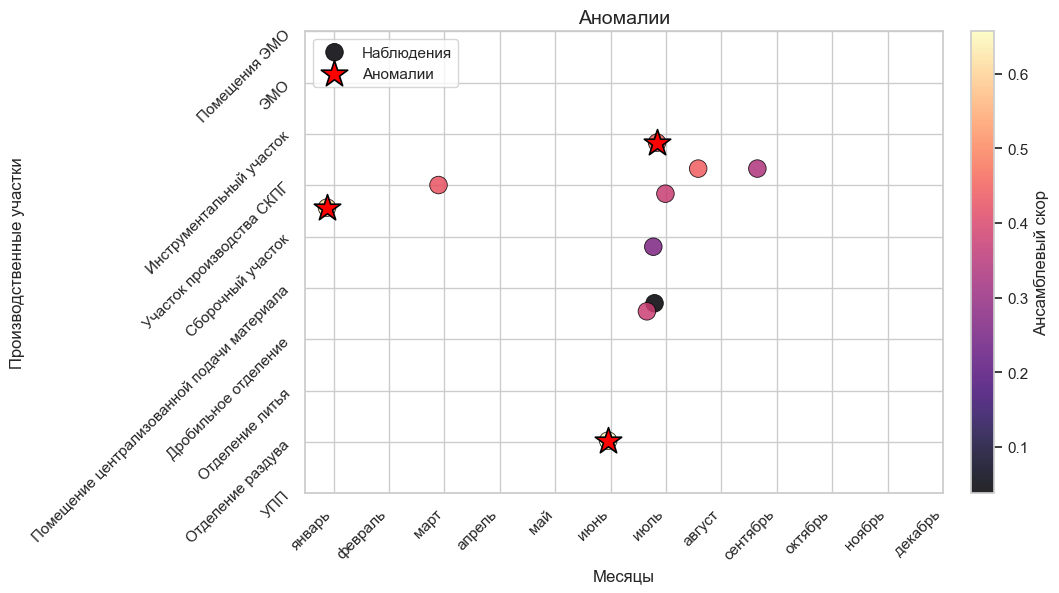

In [111]:
scores_for_plot = score_table.loc[range(10), 'ensemble_score']

fig, ax = plt.subplots(figsize=(9, 6))
points = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=scores_for_plot,
                    cmap='magma', s=160, edgecolor='black', linewidth=0.6, 
                    alpha=0.85, label='Наблюдения'
                    )

if anomalies:
    ax.scatter(X_pca[anomalies, 0], X_pca[anomalies, 1], c='red',
               s=400, marker='*', edgecolor='black', linewidth=1.2, label='Аномалии'
               )

ax.set_title('Аномалии', fontsize=14)

ax.set_xlabel('Месяцы', fontsize=12)
ax.set_ylabel('Производственные участки', fontsize=12)

ax.set_yticks(range(int(X_pca.min()), len(col)+int(X_pca.min()) if int(X_pca.min()) < 0 else len(col)-int(X_pca.min())))
ax.set_yticklabels(col, rotation=45, ha='right')

ax.set_xticks(range(int(X_pca.min()), len(months)+int(X_pca.min()) if int(X_pca.min()) < 0 else len(months)-int(X_pca.min())))
ax.set_xticklabels(months, rotation=45, ha='right')

ax.legend(loc='upper left')
fig.colorbar(points, ax=ax, fraction=0.046, pad=0.04, label='Ансамблевый скор')
plt.show()


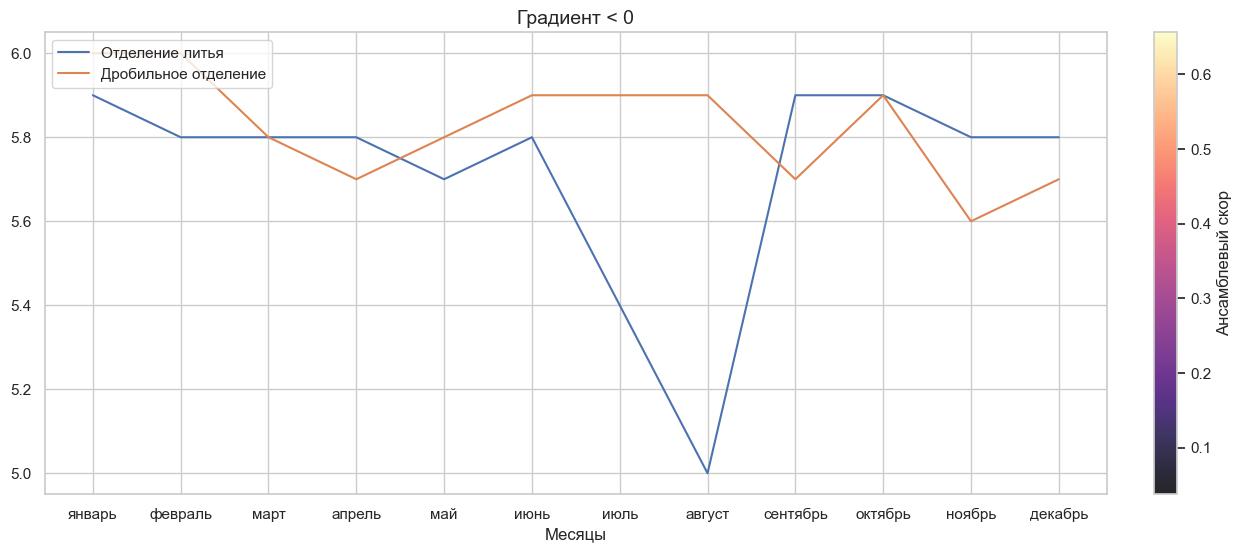

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
#ax.plot(X.T)
grad = np.gradient(X, axis=1).sum(axis=1) < 0
ax.plot(X[grad].T, label=col[grad])

ax.set_title('Градиент < 0', fontsize=14)

ax.set_xlabel('Месяцы', fontsize=12)

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

ax.legend(loc='upper left')
#fig.colorbar(points, ax=ax, fraction=0.046, pad=0.04, label='Ансамблевый скор')
plt.show()

In [184]:
def trends_by_cat(area=all, brigade=None, cat=None, data=X):
    if area != all:
        data = data[np.isin(col, area)]
    else: area = col
    #if brigade != b:
    #    brigade = b[brigade]
    #if cat != c:
    #    cat = c[cat]
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(data.T, label=area)
    ax.legend(loc='upper left')
    plt.show()

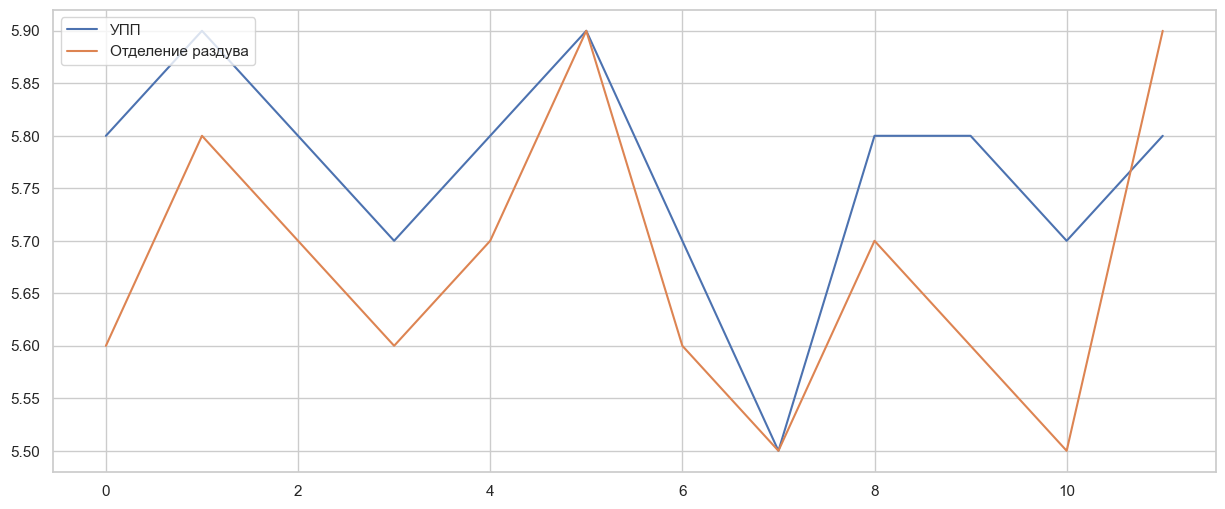

In [186]:
trends_by_cat(['УПП', 'Отделение раздува'])

In [12]:
import anomaly_visualization

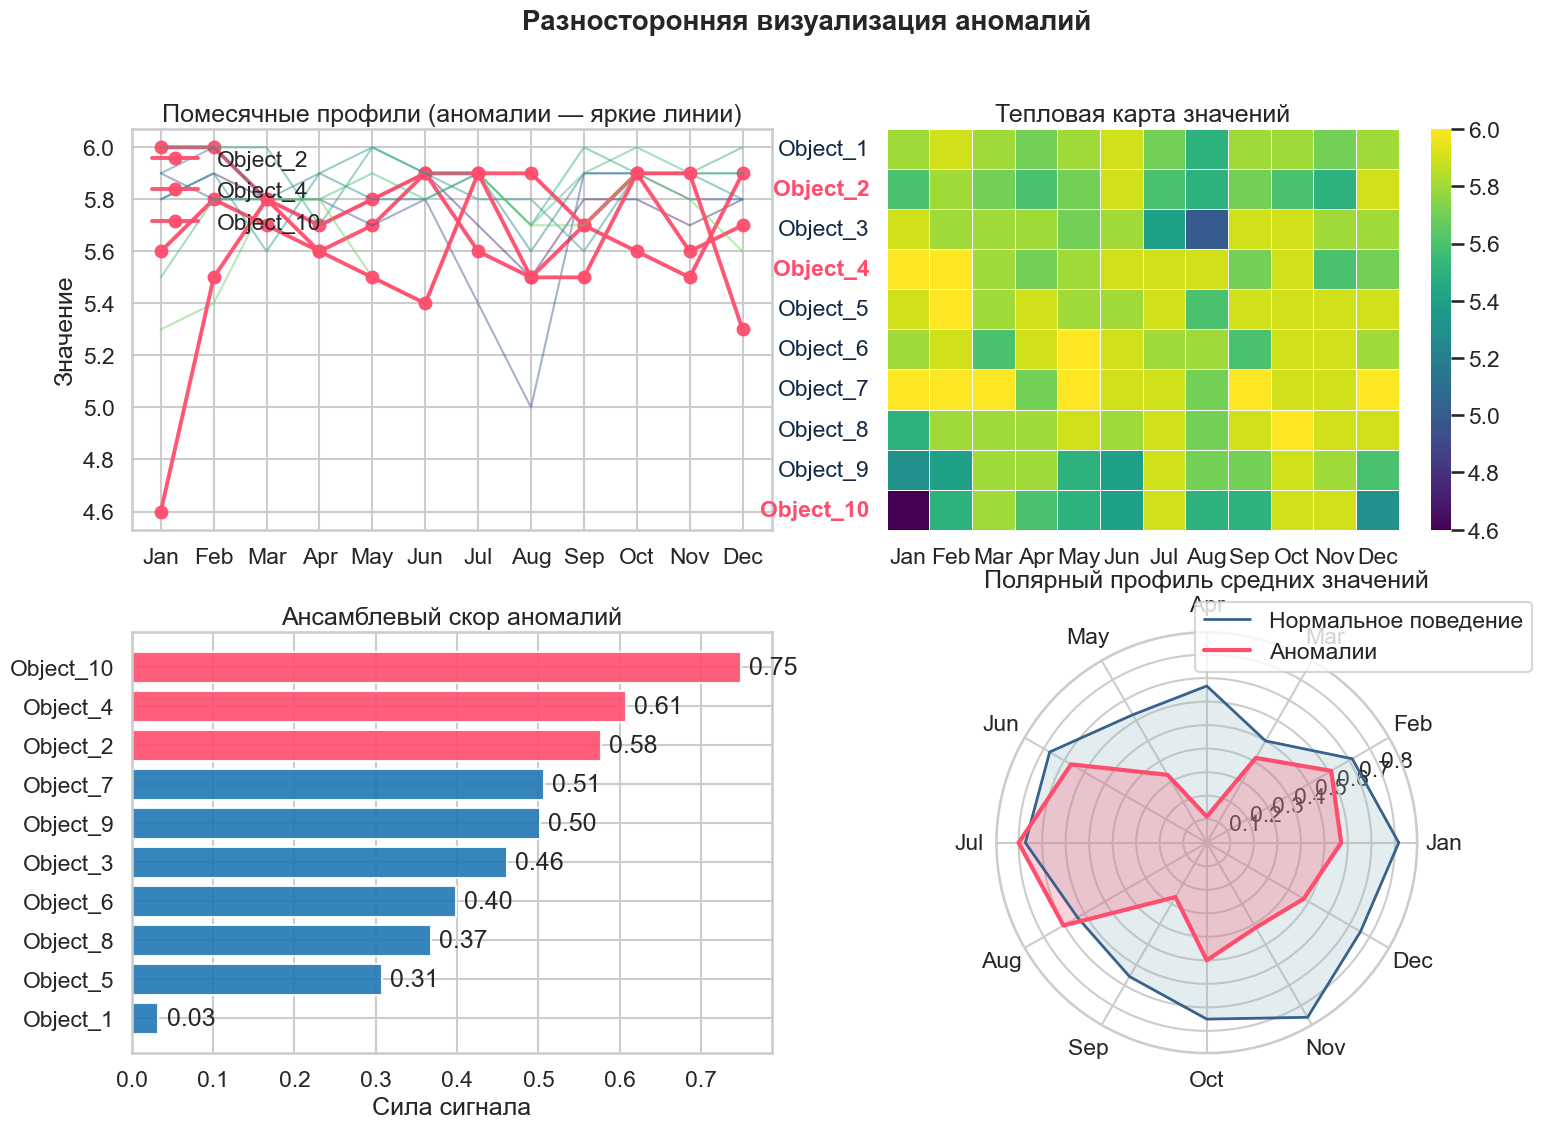

In [13]:
anomaly_visualization.main()

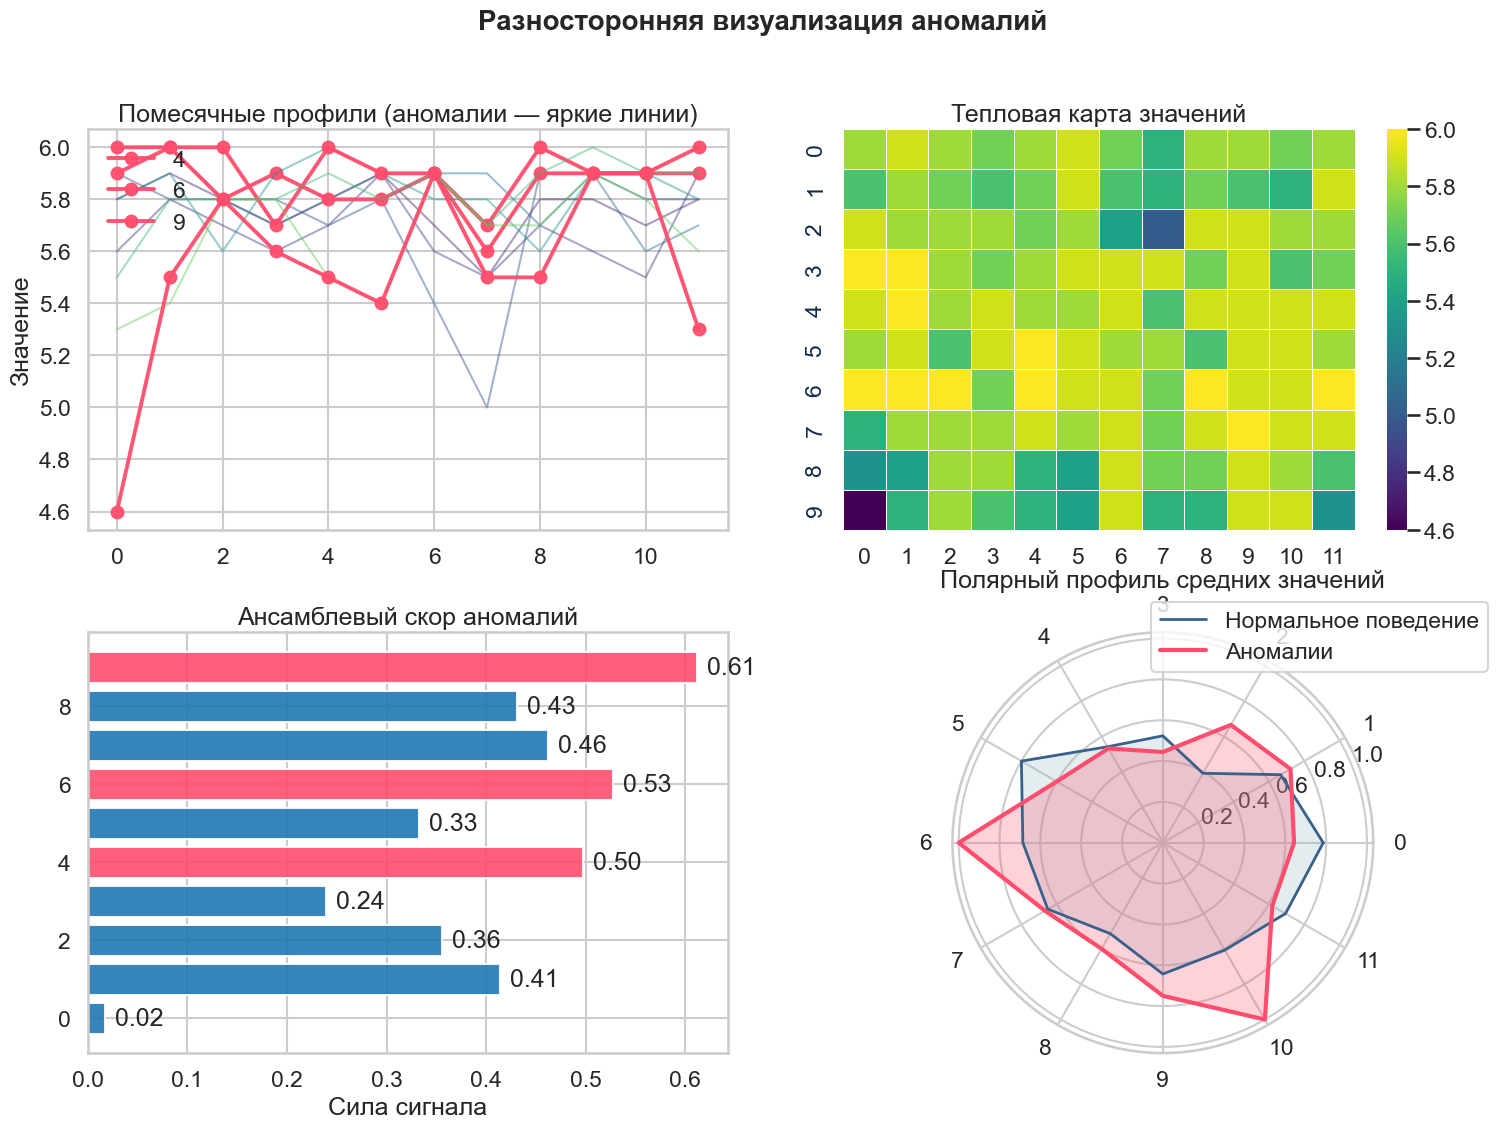

In [15]:
import anomaly_visualization as av
df = pd.DataFrame(X)
_ = av.render_dashboard(df=df, score_table=score_table, anomalies=anomalies)

In [19]:
np.median(X), X.std()

(np.float64(5.8), np.float64(0.20796467381638545))